In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F # layer without params 

import numpy as np
import matplotlib.pyplot as plt

### Docs
[Help Link](https://pytorch.org/docs/stable/nn.html)

In [2]:
class Net(nn.Module):
    def __init__(self, n_ch):
        super(Net, self).__init__()
        
        self.n_ch = n_ch
        self.conv1 = nn.Conv2d(3, self.n_ch, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(self.n_ch, self.n_ch*2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.n_ch*2, self.n_ch*4, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(self.n_ch*4*8*8, self.n_ch*4)
        self.fc2 = nn.Linear(self.n_ch*4, 6)
        
    def forward(self, x):
        # img = 3ch x 64 px x 64 px
        x = self.conv1(x) # n_channels x 64 x 64
        x = F.relu(F.max_pool2d(x,2)) # divide img by 2 -> n_channels x 32 x 32
        x = self.conv2(x) # n_channels x 32 x 32
        x = F.relu(F.max_pool2d(x,2)) # divide img by 2 -> n_channels*2 x 16 x 16
        x = self.conv3(x) # n_channels x 16 x 16
        x = F.relu(F.max_pool2d(x,2)) # divide img by 2 -> n_channels*4 x 8 x 8

        # flatten 
        x = x.view(-1, self.n_ch*4*8*8)

        # fc
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # log_softmax

        x = F.log_softmax(x, dim=1)

        return x


In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [4]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class Signs_Dataset(Dataset):
    def __init__(self, base_dir, split="train", trans=None):
        path = os.path.join(base_dir, f'{split}_signs')                              # Load the directory 
        files = os.listdir(path)                                                     # files in directory  
        self.filenames = [os.path.join(path,f) for f in files if f.endswith('.jpg')] # filenames with .jpg
        self.targets = [int(f[0]) for f in files]                                    # targets
        self.trans = trans
        
    # show class params
    def show_items(self):
        print(f'filenames -> {self.filenames[:5]} ... {self.filenames[-5:]} \ntotal: {len(self.filenames)}')
        print(f'targets -> {self.targets[:10]} ... {self.targets[-5:]} \ntotal: {len(self.targets)}')
        print(f'transform -> {self.trans}')
        
    # return length of files in the directory
    def __len__(self):
        return len(self.filenames)
    
    # return image and target
    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        if self.trans:
            image = self.trans(image)
        return image, self.targets[idx]

In [5]:
signs = Signs_Dataset('./data/64x64_SIGNS', split='train')
signs.show_items()

filenames -> ['./data/64x64_SIGNS\\train_signs\\0_IMG_5864.jpg', './data/64x64_SIGNS\\train_signs\\0_IMG_5892.jpg', './data/64x64_SIGNS\\train_signs\\0_IMG_5893.jpg', './data/64x64_SIGNS\\train_signs\\0_IMG_5894.jpg', './data/64x64_SIGNS\\train_signs\\0_IMG_5896.jpg'] ... ['./data/64x64_SIGNS\\train_signs\\5_IMG_5627.jpg', './data/64x64_SIGNS\\train_signs\\5_IMG_5628.jpg', './data/64x64_SIGNS\\train_signs\\5_IMG_5629.jpg', './data/64x64_SIGNS\\train_signs\\5_IMG_5630.jpg', './data/64x64_SIGNS\\train_signs\\5_IMG_5631.jpg'] 
total: 864
targets -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ... [5, 5, 5, 5, 5] 
total: 864
transform -> None


In [6]:
len(signs)

864

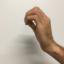

In [7]:
signs[0][0]

In [8]:
import torchvision.transforms as trasnform

In [9]:
train_set = Signs_Dataset('./data/64x64_SIGNS', split='train', trans=trasnform.ToTensor())

In [10]:
dataloader = DataLoader(train_set, batch_size=32)

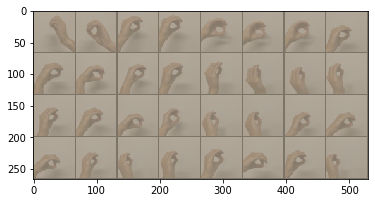

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [11]:
from torchvision.utils import make_grid
for inputs, targets in dataloader:
    out = make_grid(inputs)
    imshow(out)
    print(targets)
    break

In [12]:
import torch.optim as optim

In [13]:
device = torch.device('cuda')

In [14]:
net = Net(32).to(device) # NN 
loss_function = nn.NLLLoss() # Loss function 
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9) # Optimizer SGD

In [15]:
class RunningMetric():
    def __init__(self):
        self.S = 0 
        self.N = 0
    
    def update(self, val, size):
        self.S += val
        self.N += size
    
    def __call__(self):
        return self.S / float(self.N)
    

In [17]:
num_epochs = 100 
for epoch in range(num_epochs):
    print(f'Epoch  {epoch}/{num_epochs} ')
    print('-'*32)
    
    running_loss = RunningMetric() # Loss
    running_acc = RunningMetric()  # Accuracy
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device) # to gpu
        optimizer.zero_grad() # to reset optimizer
        outputs = net(inputs)
        _, pred = torch.max(outputs, 1)
        loss = loss_function(outputs, targets)
        
        loss.backward() # auto calculate gradients 
        optimizer.step() # update params
        
        
        batch_size = inputs.size()[0]
        running_loss.update(loss.item()*batch_size, 
                            batch_size) # update loss
        running_acc.update(torch.sum(pred == targets).float(), 
                           batch_size) # update accuracy
        
    print(f'Loss: {running_loss():.4f} Accuracy: {running_acc():.4f}')

Epoch  0/100 
--------------------------------
Loss: 1.7018 Accuracy: 0.2685
Epoch  1/100 
--------------------------------
Loss: 1.6364 Accuracy: 0.3403
Epoch  2/100 
--------------------------------
Loss: 1.6948 Accuracy: 0.2569
Epoch  3/100 
--------------------------------
Loss: 1.7215 Accuracy: 0.2292
Epoch  4/100 
--------------------------------
Loss: 1.6886 Accuracy: 0.2778
Epoch  5/100 
--------------------------------
Loss: 1.7592 Accuracy: 0.2257
Epoch  6/100 
--------------------------------
Loss: 1.6509 Accuracy: 0.3391
Epoch  7/100 
--------------------------------
Loss: 1.5610 Accuracy: 0.3912
Epoch  8/100 
--------------------------------
Loss: 1.6076 Accuracy: 0.3507
Epoch  9/100 
--------------------------------
Loss: 1.5343 Accuracy: 0.4074
Epoch  10/100 
--------------------------------
Loss: 1.5429 Accuracy: 0.3773
Epoch  11/100 
--------------------------------
Loss: 1.5380 Accuracy: 0.3912
Epoch  12/100 
--------------------------------
Loss: 1.5119 Accuracy: 0.4

## Model optimization

In [18]:
train_set = Signs_Dataset('./data/64x64_SIGNS', split='train', trans=trasnform)
train_loader = DataLoader(train_set, batch_size=32)

In [19]:
validation_set = Signs_Dataset('./data/64x64_SIGNS', split='val', trans=trasnform)
validation_loader = DataLoader(validation_set, batch_size=32)

In [20]:
test_set = Signs_Dataset('./data/64x64_SIGNS', split='test', trans=trasnform)
test_loader = DataLoader(test_set, batch_size=32)

In [21]:
dataloaders = {
    'train':train_loader,
    'val': validation_loader,
    'test': test_loader
}

In [22]:
from torchvision import transforms

# Data augmentation

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5, 0.5,0.5))
    ]
)


In [23]:
class Net(nn.Module):
    def __init__(self, n_ch):
        super(Net, self).__init__()
        
        self.n_ch = n_ch
        
        self.conv1 = nn.Conv2d(3, self.n_ch, kernel_size=3, stride=1, padding=1) 
        self.bn1 = nn.BatchNorm2d(self.n_ch) # Batch Norm Layers
        
        self.conv2 = nn.Conv2d(self.n_ch, self.n_ch*2, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.n_ch*2)
        
        self.conv3 = nn.Conv2d(self.n_ch*2, self.n_ch*4, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.n_ch*4)
        
        self.fc1 = nn.Linear(self.n_ch*4*8*8, self.n_ch*4)
        self.fcbn1 = nn.BatchNorm1d(self.n_ch*4*8*8)
        self.fc2 = nn.Linear(self.n_ch*4, 6)
        
    def forward(self, x):
        # img = 3ch x 64 px x 64 px
        
        # Regularization
        x = self.bn1(self.conv1(x)) # n_channels x 64 x 64
        x = F.relu(F.max_pool2d(x,2)) # divide img by 2 -> n_channels x 32 x 32
        x = self.bn2(self.conv2(x)) # n_channels x 32 x 32
        x = F.relu(F.max_pool2d(x,2)) # divide img by 2 -> n_channels*2 x 16 x 16
        x = self.bn3(self.conv3(x)) # n_channels x 16 x 16
        x = F.relu(F.max_pool2d(x,2)) # divide img by 2 -> n_channels*4 x 8 x 8

        # flatten 
        x = x.view(-1, self.n_ch*4*8*8)

        # fc
        x = F.relu(self.fcbn1(self.fc1(x)))
        x = F.dropout(x, p=0.8, training=True)
        x = self.fc2(x)

        # log_softmax

        x = F.log_softmax(x, dim=1)

        return x


In [24]:
num_epochs = 100 

def train_and_eval(model, optimizer, loss_function, dataloaders, device, num_epochs=10, lr=0.001):
    
    # Update learning rate of my optimizer
    for p in optimizer.param_groups:
        p['lr'] = lr
    
    
    for epoch in range(num_epochs):
        print(f'Epoch  {epoch}/{num_epochs} ')
        print('-'*32)

        # phase of our model
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
        
            running_loss = RunningMetric() # Loss
            running_acc = RunningMetric()  # Accuracy

            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device) # to gpu
                optimizer.zero_grad() # to reset optimizer
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(inputs)
                    _, pred = torch.max(outputs, 1)
                    loss = loss_function(outputs, targets)
                    
                    if phase == 'train':
                        loss.backward() # auto calculate gradients 
                        optimizer.step() # update params


                batch_size = inputs.size()[0]
                running_loss.update(loss.item()*batch_size, 
                                    batch_size) # update loss
                running_acc.update(torch.sum(pred == targets).float(), 
                                   batch_size) # update accuracy

            print(f'Loss: {running_loss():.4f} Accuracy: {running_acc():.4f}')
    
    return model

In [25]:
import random

lrs = [10**(-random.randint(3,7)) for _ in range(3)]
print(lrs)
for lr in lrs:
    train_and_eval(net, optimizer, loss_function, dataloaders, device, 10, lr)

[1e-05, 0.0001, 0.0001]
Epoch  0/10 
--------------------------------
Loss: 0.0084 Accuracy: 1.0000
Loss: 0.0083 Accuracy: 1.0000
Epoch  1/10 
--------------------------------
Loss: 0.0083 Accuracy: 1.0000
Loss: 0.0083 Accuracy: 1.0000
Epoch  2/10 
--------------------------------
Loss: 0.0083 Accuracy: 1.0000
Loss: 0.0083 Accuracy: 1.0000
Epoch  3/10 
--------------------------------
Loss: 0.0083 Accuracy: 1.0000
Loss: 0.0083 Accuracy: 1.0000
Epoch  4/10 
--------------------------------
Loss: 0.0083 Accuracy: 1.0000
Loss: 0.0083 Accuracy: 1.0000
Epoch  5/10 
--------------------------------
Loss: 0.0083 Accuracy: 1.0000
Loss: 0.0083 Accuracy: 1.0000
Epoch  6/10 
--------------------------------
Loss: 0.0083 Accuracy: 1.0000
Loss: 0.0083 Accuracy: 1.0000
Epoch  7/10 
--------------------------------
Loss: 0.0083 Accuracy: 1.0000
Loss: 0.0083 Accuracy: 1.0000
Epoch  8/10 
--------------------------------
Loss: 0.0083 Accuracy: 1.0000
Loss: 0.0083 Accuracy: 1.0000
Epoch  9/10 
---------

## Evaluation

In [26]:
model = train_and_eval(net, optimizer, loss_function, dataloaders,device, 10, 0.0001)

Epoch  0/10 
--------------------------------
Loss: 0.0076 Accuracy: 1.0000
Loss: 0.0075 Accuracy: 1.0000
Epoch  1/10 
--------------------------------
Loss: 0.0076 Accuracy: 1.0000
Loss: 0.0074 Accuracy: 1.0000
Epoch  2/10 
--------------------------------
Loss: 0.0076 Accuracy: 1.0000
Loss: 0.0074 Accuracy: 1.0000
Epoch  3/10 
--------------------------------
Loss: 0.0075 Accuracy: 1.0000
Loss: 0.0074 Accuracy: 1.0000
Epoch  4/10 
--------------------------------
Loss: 0.0075 Accuracy: 1.0000
Loss: 0.0073 Accuracy: 1.0000
Epoch  5/10 
--------------------------------
Loss: 0.0075 Accuracy: 1.0000
Loss: 0.0073 Accuracy: 1.0000
Epoch  6/10 
--------------------------------
Loss: 0.0074 Accuracy: 1.0000
Loss: 0.0073 Accuracy: 1.0000
Epoch  7/10 
--------------------------------
Loss: 0.0074 Accuracy: 1.0000
Loss: 0.0073 Accuracy: 1.0000
Epoch  8/10 
--------------------------------
Loss: 0.0074 Accuracy: 1.0000
Loss: 0.0072 Accuracy: 1.0000
Epoch  9/10 
--------------------------------


In [27]:
test_set = Signs_Dataset('./data/64x64_SIGNS', split='test', trans=trasnform.ToTensor())
test_loader = DataLoader(test_set, batch_size=32)

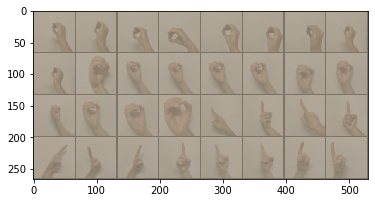

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


In [28]:
inputs_out = []
outputs = []

for inputs, targets in test_loader:
    inputs_out = inputs
    out = make_grid(inputs)
    imshow(out)
    print(targets)
    inputs, targets = inputs.to(device), targets.to(device) # to gpu
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1)
    print(pred)
    break


##  Transfer Lerarning

One of many ways to see transfer learning is to take into account the values ​​of the neurons of the internal layers of the network are features. In this case we will look at the penultimate layer of a deep network already trained:

These features were calculated by gradient training on large public datasets like ImageNet, therefore they contain a lot of information.

We will use the neural network only as preprocessing to obtain the features of the penultimate layer.

The main idea is to build a traditional classifier (therefore not deep) based on these features and train it with our dataset.

Let's remember that almost always the last layer of a deep neural network is a linear layer (fully connected) so to accomplish our purpose we would only have to drop this layer and add a classifier above it.

Traditional classifiers can be: logistic regression, linear classification, SVM, tree-based classifiers, etc.

Pre-trained deep nets are already very complex for the most part, and therefore their features are very expressive. A simple but effective solution is to add a linear layer to the end of the network, that is, to make a simple linear classification above the features.

In [29]:
from torchvision import models
vgg = models.vgg16(pretrained=True)
vgg = vgg.to(device)

I disable the gradient of all the parameters of the network
This is done because we do not want to continue changing the parameter values. The network already has a good combination of values to calculate features, and the training will be carried out only in the additional layer that we will add.

In [30]:
for param in vgg.parameters():
  param.requires_grad = False

We extract the last layer of the network
VGG was built using nn.Sequential. This means that the "last layer" is actually many layers together. For this reason, we must call the children method twice to access the last linear layer.

In [31]:
last_sequential_layer = list(vgg.children())[-1]
*list_of_layers, last_layer = list(last_sequential_layer.children())
in_features = last_layer.in_features

To keep order I leave in the same classifier attribute all the last layers that were in nn.Sequential, less obviously the last one, plus the new linear layer that I want to train and therefore I enable the gradient.

In [32]:
vgg.fc = nn.Linear(in_features,6)
vgg.fc.requires_grad = True
vgg.classifier = nn.Sequential(*(list_of_layers+[vgg.fc]))

Transfer learning basically consists of initializing the parameters of a network with good initial values, extracted from the training of the network on a public dataset.

There are 4 ways to transfer learning and these depend directly on the domain and size of the image dataset.

I launch the training
A little tip. In general, pre-trained networks were trained with datasets that had a certain mean and standard deviation. It is recommended that this mean and variance be used in the preprocessing pipeline.

In [33]:
transform = transforms.Compose(
  [transforms.RandomHorizontalFlip(), #data augmentation
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    
  ]
)

trainset = Signs_Dataset('./data/64x64_SIGNS', split="train", trans = transform)
trainloader = DataLoader(trainset,batch_size=32)

valset = Signs_Dataset('./data/64x64_SIGNS', split="val", trans = transform)
valloader = DataLoader(trainset,batch_size=32)

testset = Signs_Dataset('./data/64x64_SIGNS', split="test", trans = transform)
testloader = DataLoader(trainset,batch_size=32)

dataloaders = {'train':trainloader,
              'val':valloader,
              'test':testloader}

In [34]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)

train_and_eval(vgg, optimizer, loss_fn, dataloaders, device, num_epochs = 100)

Epoch  0/100 
--------------------------------
Loss: 0.0087 Accuracy: 1.0000
Loss: 0.0072 Accuracy: 1.0000
Epoch  1/100 
--------------------------------
Loss: 0.0096 Accuracy: 1.0000
Loss: 0.0070 Accuracy: 1.0000
Epoch  2/100 
--------------------------------
Loss: 0.0080 Accuracy: 1.0000
Loss: 0.0065 Accuracy: 1.0000
Epoch  3/100 
--------------------------------
Loss: 0.0081 Accuracy: 1.0000
Loss: 0.0064 Accuracy: 1.0000
Epoch  4/100 
--------------------------------
Loss: 0.0073 Accuracy: 1.0000
Loss: 0.0060 Accuracy: 1.0000
Epoch  5/100 
--------------------------------
Loss: 0.0074 Accuracy: 1.0000
Loss: 0.0059 Accuracy: 1.0000
Epoch  6/100 
--------------------------------
Loss: 0.0067 Accuracy: 1.0000
Loss: 0.0056 Accuracy: 1.0000
Epoch  7/100 
--------------------------------
Loss: 0.0067 Accuracy: 1.0000
Loss: 0.0054 Accuracy: 1.0000
Epoch  8/100 
--------------------------------
Loss: 0.0062 Accuracy: 1.0000
Loss: 0.0051 Accuracy: 1.0000
Epoch  9/100 
-----------------------

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

A more general way of looking at Transfer Learning is to understand it as a way to intelligently initialize parameters (weight initialization).

There are more ways to initialize these parameters, such as a random initialization, or Xavier initialization. However, transfer learning is by far the most powerful initialization since the parameters of a deep network contain very valuable information. In the following paper we can understand more of this and see that:

<img src="https://i.imgur.com/UuOYojP.jpg">

- In a convolutional network the parameters seen as a whole (parameters of the same channel) can be understood as a filter. This is how the filters you know and transform the look of an image.
- The filters of the first layers in a deep network perform very general actions: they can extract colors, textures and borders.
- The filters in the deepest layers are closely linked to the domain from which the photos come and are already more specific and therefore less abstract than the first filters. For example, in the case of a face dataset, the filters will recognize concepts linked to a face such as noses, eyes, ears, etc. These filters are said to be specific to the face domain, which would clearly be less useful for recognizing cars for example.

The technique we used previously (extraction of features) corresponds to a particular case of Transfer Learning. This is for example when the dataset you have is small (ours has a few thousand images), or when the domain of your dataset is very different from the one used to train the network.

In total there are 4 cases to consider for Transfer Learning:

|Dataset | size | Domain Transfer |
|:-------|:-----:|:---------------|
|Small | Similar | Replace top coat. Just train last layer. |
|Large | Similar | Replace top coat. Train the entire network. |
|Small | Different | Drop multiple final layers and put additional layer only on a layer that has non-domain specific features. Just train last layer. |
|Large | Different | Replace top coat. Train the entire network.| 

# For More:
[the-incredible-pytorch](https://github.com/ritchieng/the-incredible-pytorch)